## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [3]:
# sample 5000 rows for writing code
congress_tweets = congress_tweets.sample(n = 5000, random_state = 10)

In [4]:
congress_tweets['text']

36257     Before adopting Olivia, we spent a great amoun...
548996    Are we supposed to take Trump seriously or lit...
652347    Thank you to Lieutenant Mike Tarr and Fire Chi...
267614    Made remarks to @AmFreeSyria sharing my concer...
344386    @jeroneanderson @MontcoLP @LelandShow @realDon...
                                ...                        
745540    Thank you @honorair for organizing these meani...
832336    RT @HouseGOP 🚨 NEW: @China_TaskForce releases ...
53451     The President has worked dilligenty since his ...
758647    RT @BobMooreNews "It's not OK to say that all ...
201571    As a combat veteran and member of the @Nationa...
Name: text, Length: 1000, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

First, we create two dictionaries to add to the default stop words -- one that has a bunch of html gunk, and another that has popular Twitter abbreviations.

In [4]:
gunk = {'\n',
 '\n\n',
 '\n\n\n',
 '\n\n\n\n',
 '\n\n ',
 '\n\n\xa0 ',
 '\n ',
 '\n \n',
 '\n \n ',
 '\n  ',
 '\n   ',
 '\n\xa0\n',
 ' ',
 ' \n',
 ' \n\n',
 ' \n ',
 '  ',
 '  \n\n ',
 '   ',
 '     ',
 '"',
 "'",
 '-PRON-','’	','—','’',
        '\n\n  ',
 '\n\n         ',
 '\n   \n',
 '\n      ',
 '\n           ',
 ' \n\n ',
 ' \n \n',
 '  \n',
 '  \n\n',
 '    ',
 '           ',
 '         \u3000\u3000\n         '} # there's probably a more elegant way to do this than what I did

twitter_abbreviations = {'mt','rt','dm','prt','ht','cc'} 
# lifted from https://www.businessinsider.com/twitter-acronyms-2012-4

In [5]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    # adds twitter abbreviations to stop words
    nlp.Defaults.stop_words |= twitter_abbreviations
    
    nlp.Defaults.stop_words |= gunk
    
    # removes punctuation and digits, converts to lowercase
    punc_free = "".join([ch for ch in text if ch not in punc if not ch.isdigit()]).lower()
    
    # we could remove emojis, but they don't seem to trip up spaCy. Still need to get this to work
    # punc_emoji_free = give_emoji_free_text(punc_free)
    
    doc = nlp(punc_free)
    
    # lemmatizes rather than just tokenizing
    spacy_words = [token.lemma_ for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    # my more elegant way of removing the new lines lies broken here
    #spacy_words = [ x for x in spacy_words if '\n' in x ]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [6]:
congress_tweets['tokens'] = [rem_punc_stop(x) for x in congress_tweets['text']]
congress_tweets['tokens'] # note -- -PRON- refers to pronoun, the lemmatizer does this

36257     [adopt, olivia, spend, great, time, learn, ari...
548996    [suppose, trump, seriously, literally, steel, ...
652347    [thank, lieutenant, mike, tarr, fire, chief, o...
267614    [remark, amfreesyria, share, concern, devastat...
344386    [jeroneanderson, montcolp, lelandshow, realdon...
                                ...                        
808467    [jimjordan, house, democrats, demand, illegal,...
708752       [signewilk, super, spreader, president, motor]
7587      [confident, congress, act, week, replenish, re...
930878    [laurenblanch, study, extra, week, finalexam, ...
277874    [measle, vaccine, save, million, life, globall...
Name: tokens, Length: 5000, dtype: object

In [8]:
# peek at the tokens
#tokens_reduced = []
#tokens_reduced = [tokens_reduced.append(word) for word in congress_tweets['tokens']]

Now that we've obtained the lemmas for each tweet, we'll want to count them for text featurization. One way to do this is via the bag-of-words approach. We'll use the function that we built to remove the stop words and punctuation, and lemmatize, to initialize our CountVectorizer.

In [47]:


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import scipy.sparse as sp

def dummy_fun(doc):
    return doc





In [40]:
bow_vector = CountVectorizer(analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None, ngram_range=(1,1))

bow_vector.fit(congress_tweets['tokens'])

bow_matrix = sp.vstack([bow_vector.transform([x]) for x in congress_tweets['tokens']])


#bow_matrix = bow_vector.fit_transform(congress_tweets['text'])
#bow_matrix.todense()

In [42]:
feature_names = bow_vector.get_feature_names()
feature_names[0:50] # peek at our features

['aacuna',
 'aal',
 'aalayaheastmond',
 'aalcsummit',
 'aapi',
 'aapmhq',
 'aaron',
 'aaronkatersky',
 'aarpde',
 'aarppa',
 'aarpsc',
 'aba',
 'abandon',
 'abandonment',
 'abbas',
 'abbott',
 'abbydphillip',
 'abc',
 'abcmichellem',
 'abcnews',
 'abcnewslive',
 'abcpolitics',
 'abdicate',
 'abdication',
 'abe',
 'abel',
 'abhor',
 'abhorrent',
 'abide',
 'abierta',
 'ability',
 'abject',
 'able',
 'ably',
 'aboard',
 'abolish',
 'abolishthedeathpenalty',
 'abolitionist',
 'abordar',
 'abortion',
 'abortionist',
 'abqschools',
 'abraham',
 'abrams',
 'abroad',
 'abrupt',
 'abruptly',
 'absence',
 'absent',
 'absentee']

In [ ]:
#http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
#grabbed some stuff from here to avoid re-tokenizing! 



tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

tfidf.fit(congress_tweets['tokens'])

In [55]:
tfidf_matrix = sp.vstack([tfidf.transform([x]) for x in congress_tweets['tokens']])

Great, these feature names seem fairly reasonable. However, the tf-idf matrix is an extension of the bag-of-words approach that should be more helpful to us, because it removes very common words that don't add much to the analysis.

In [11]:
#tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop)
#matrix = tfidf_vector.fit_transform(congress_tweets['text'])
#matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
feature_names = tfidf.get_feature_names()
feature_names

['aacuna',
 'aal',
 'aalayaheastmond',
 'aalcsummit',
 'aapi',
 'aapmhq',
 'aaron',
 'aaronkatersky',
 'aarpde',
 'aarppa',
 'aarpsc',
 'aba',
 'abandon',
 'abandonment',
 'abbas',
 'abbott',
 'abbydphillip',
 'abc',
 'abcmichellem',
 'abcnews',
 'abcnewslive',
 'abcpolitics',
 'abdicate',
 'abdication',
 'abe',
 'abel',
 'abhor',
 'abhorrent',
 'abide',
 'abierta',
 'ability',
 'abject',
 'able',
 'ably',
 'aboard',
 'abolish',
 'abolishthedeathpenalty',
 'abolitionist',
 'abordar',
 'abortion',
 'abortionist',
 'abqschools',
 'abraham',
 'abrams',
 'abroad',
 'abrupt',
 'abruptly',
 'absence',
 'absent',
 'absentee',
 'absolute',
 'absolutely',
 'absurd',
 'absurdity',
 'abt',
 'abu',
 'abundance',
 'abuse',
 'abuser',
 'abusive',
 'abysmal',
 'ac',
 'aca',
 'acaanniversary',
 'academic',
 'academics',
 'academy',
 'acarrillonews',
 'acc',
 'accelerate',
 'accept',
 'acceptable',
 'acceptance',
 'accesible',
 'acceso',
 'access',
 'accessibility',
 'accessible',
 'accident',
 'accomm

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: A look at the top n-grams

We'll want to visualize the most commonly-used words and phrases in our dataset. First, we'll try unigrams.

In [44]:
# initialize the BOW countervectorizer with ngram_range argument
#countvec = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))
#ngrams = countvec.fit_transform(congress_tweets['text'])

dictionary_dataframe = pd.DataFrame(bow_matrix.todense(), columns = bow_vector.get_feature_names())

In [45]:
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head() # take a peek

# interesting. What the heck is 'amp'? Am I just old...?
# hmm, could it be ampersand? -P
# that's a good guess Paul, I have no idea what amp is. I, too, am old lol -JS

,ngrams,freq
0,amp,1271
1,today,735
2,qt,732
3,work,538
4,need,516


Okay, but pretty devoid of context. Let's calculate and visualize the top 25 bigrams.

In [46]:
# initialize the BOW countervectorizer with ngram_range argument up to 2
# this is where i can see us re-tokenizing so that we get 2-grams

countvec = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(2,2))
ngrams = countvec.fit_transform(congress_tweets['text'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


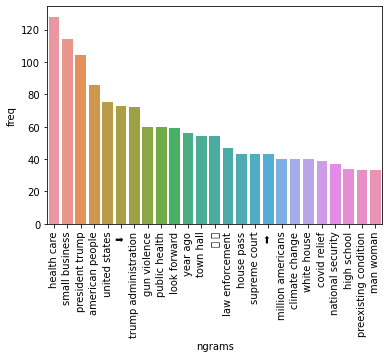

In [48]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

The bigrams seem pretty intelligible indeed. Healthcare was tweeted about the most, with President Trump as a close second. Small business comes in third. It will be interesting to understand the extent to which themes of health versus economy sort themselves along party lines. Likewise, it will be interesting to understand the sentiment of the tweets mentioning Trump, and the extent to which it falls along party lines or legislative chambers. For example, if we hypothesize that the Senate is the "cooling saucer" of Congress, perhaps senators' tweets refrain from critiquing Trump.

### EDA 2: A first pass at LDA

How do these tokens combine to compose topics in the 116th Congressional tweets? Let's use LDA to take an initial look. First, we'll create our tf-idf matrix.

In [17]:
# don't need to re-run tfidf fit_transform here, already have it from above

X = congress_tweets['text']
#tf = TfidfVectorizer(tokenizer = rem_punc_stop)

#tfidf_matrix =  tf.fit_transform(X)
#dense_matrix = tfidf_matrix.todense()

We'll fit the LDA model, arbitrarily starting with five topics.

In [67]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda = lda.fit(tfidf_matrix)

In [52]:
lda.n_components

6

We'll get the top tokens for each of our five topics, and print them along with our feature names.

In [68]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [69]:
tf_feature_names = tfidf.get_feature_names()
print_top_words(lda, tf_feature_names, 30)


Topic #0:
🇸 🇺 puerto drop rico newsletter whistleblower adam preexisting ahead lawsuit markwarner prescription postal rush sad schiff la publicly nato underway maternal en box schedule rich trillion recap de easter

Topic #1:
getcovere saudi murder farm brown exonerate pursue muellerhearing oppression organization secazar actually floyd injustice arabia brief statue alzheimer wellbeing gathering effectively thought putin party maskup 🇺 enoughisenough stater relate hazard

Topic #2:
postal de email breast peaceful hunter la y coverup foxnew cancer defunde bed christmas date lend    mother usdol draw tweet brutality presidency whistleblower progressive michael 🏾 pursuit calendar los

Topic #3:
location desk renter eviction resilient truly extension environmental dependent loophole uncertain contractor valley presidentelect lowerdrugcost helpful fossil el refusal fuel suppression item moratorium overwhelmingly veto alarm rely september medicine stayhome

Topic #4:
beach de column invite 

The topics don't seem super well-separated or coherent, so we may have to play around with the number of components. For example, 4 out of 5 of the topics contain "covid" or coronavirus. This might not be totally worrisome, except that they don't appear to be very distinct in other respects -- most mention work and voting, as well as Congress and the president. Topic 3 appears the most distinact, perhaps a bit antagonistic to Trump or impeachment-related -- it is the only one that does not mention the president or health, but "impeachment" as well as words like "crisis," "fight," "act," "people," and "protect."

Checking the topic distributions for separation across our categories of interest: party and Congress vs. Senate. 

In [70]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.01621883, 0.01621895, 0.01621878, ..., 0.01621947, 0.01621901,
        0.29786607],
       [0.02439836, 0.0244    , 0.02439916, ..., 0.02439981, 0.02439836,
        0.0243998 ],
       [0.02472419, 0.02472419, 0.48596399, ..., 0.02472424, 0.0247242 ,
        0.3162135 ],
       ...,
       [0.07637898, 0.01855099, 0.01855075, ..., 0.01855534, 0.01854886,
        0.72635853],
       [0.02436986, 0.02437225, 0.02436986, ..., 0.02437127, 0.02437081,
        0.02437467],
       [0.39524747, 0.01981197, 0.0198126 , ..., 0.01981196, 0.01981164,
        0.0198179 ]])

In [71]:
topic_dist_df = pd.DataFrame(topic_dist, columns = ["Topic " + str(x) for x in range(0, lda.n_components)])
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,0.016219,0.016219,0.016219,0.016219,0.016219,0.480253,0.108348,0.016219,0.016219,0.297866,...,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[adopt, olivia, spend, great, time, learn, ari..."
1,0.024398,0.024400,0.024399,0.368240,0.024398,0.436568,0.024399,0.024400,0.024398,0.024400,...,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[suppose, trump, seriously, literally, steel, ..."
2,0.024724,0.024724,0.485964,0.024725,0.024724,0.024751,0.024725,0.024724,0.024724,0.316213,...,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[thank, lieutenant, mike, tarr, fire, chief, o..."
3,0.017479,0.017482,0.321381,0.017479,0.017479,0.538783,0.017479,0.017479,0.017480,0.017481,...,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[remark, amfreesyria, share, concern, devastat..."
4,0.028129,0.530788,0.028125,0.028125,0.028126,0.244202,0.028125,0.028125,0.028125,0.028129,...,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, montcolp, lelandshow, realdon..."


In [72]:
grouped = df_w_topics.groupby('party')
for i in df_w_topics.columns[0:lda.n_components]:
    print(grouped[i].mean().sort_values(ascending=False))

party
Democrat       0.047849
Republican     0.047240
Independent    0.019567
Name: Topic 0, dtype: float64
party
Independent    0.077993
Republican     0.049775
Democrat       0.049318
Name: Topic 1, dtype: float64
party
Republican     0.046324
Democrat       0.042628
Independent    0.026627
Name: Topic 2, dtype: float64
party
Democrat       0.051347
Republican     0.049645
Independent    0.035831
Name: Topic 3, dtype: float64
party
Republican     0.042950
Democrat       0.039059
Independent    0.023458
Name: Topic 4, dtype: float64
party
Democrat       0.477196
Republican     0.472541
Independent    0.384411
Name: Topic 5, dtype: float64
party
Independent    0.109921
Republican     0.046725
Democrat       0.041535
Name: Topic 6, dtype: float64
party
Democrat       0.045340
Republican     0.044004
Independent    0.023218
Name: Topic 7, dtype: float64
party
Republican     0.044394
Independent    0.042231
Democrat       0.041298
Name: Topic 8, dtype: float64
party
Independent    0.25674

In [73]:
grouped = df_w_topics.groupby('position')
for i in df_w_topics.columns[0:lda.n_components]:
    print(grouped[i].mean().sort_values(ascending=False))
    

position
Rep    0.048467
Sen    0.044712
Name: Topic 0, dtype: float64
position
Sen    0.049914
Rep    0.049452
Name: Topic 1, dtype: float64
position
Rep    0.044214
Sen    0.042863
Name: Topic 2, dtype: float64
position
Rep    0.051235
Sen    0.049047
Name: Topic 3, dtype: float64
position
Rep    0.041441
Sen    0.037120
Name: Topic 4, dtype: float64
position
Sen    0.491569
Rep    0.470006
Name: Topic 5, dtype: float64
position
Sen    0.043686
Rep    0.043534
Name: Topic 6, dtype: float64
position
Sen    0.045770
Rep    0.044489
Name: Topic 7, dtype: float64
position
Rep    0.043037
Sen    0.040401
Name: Topic 8, dtype: float64
position
Rep    0.164125
Sen    0.154917
Name: Topic 9, dtype: float64


## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [74]:
#Convert name_wikipedia column to string 
congress_tweets['name_wikipedia'] = congress_tweets.name_wikipedia.apply(str)
congress_tweets['name_wikipedia']

36257         David Schweikert
548996    Sean Patrick Maloney
652347            Steve Chabot
267614               Jim Risch
344386           Thomas Massie
                  ...         
808467             Brian Babin
708752            Dwight Evans
7587               Martha Roby
930878              Sean Duffy
277874             Bill Foster
Name: name_wikipedia, Length: 5000, dtype: object

In [75]:
#Conservative rep - Chip Roy
congress_tweets['tokens_sent'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
roy_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Chip Roy']
roy_tweets['polarity'] = roy_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.polarity)
roy_tweets['subjectivity'] = roy_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.subjectivity)
roy_tweets

<ipython-input-75-bfd277a971a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roy_tweets['polarity'] = roy_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-75-bfd277a971a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roy_tweets['subjectivity'] = roy_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.subjectivity)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_sent,polarity,subjectivity
774657,1.138850e+18,RepChipRoy,2019-06-12T12:40:04-04:00,"RT @ESCochrane Chip Roy, the first to block th...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[escochrane, chip, roy, block, disaster, relie...",escochrane chip roy block disaster relief bill...,0.000000,0.000000
781867,1.169610e+18,RepChipRoy,2019-09-05T10:01:22-04:00,"2,347 ounces of heroin was seized on the south...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[ounce, heroin, seize, southw, border, july, s...",ounce heroin seize southw border july stateofo...,0.000000,0.000000
802508,1.234970e+18,RepChipRoy,2020-03-03T17:49:58-05:00,I had the privilege of meeting with @ICEgov to...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[privilege, meeting, icegov, today, tell, lack...",privilege meeting icegov today tell lack resou...,0.154167,0.670833
792018,1.201550e+18,RepChipRoy,2019-12-02T12:28:47-05:00,Annual employer-sponsored family insurance top...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[annual, employersponsored, family, insurance,...",annual employersponsored family insurance new ...,0.174091,0.498636
766784,1.110620e+18,RepChipRoy,2019-03-26T15:24:49-04:00,RT @RepRonWright Read this! Having just return...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[repronwright, read, return, border, strongly,...",repronwright read return border strongly concu...,-0.022222,0.444444
803413,1.237850e+18,RepChipRoy,2020-03-11T17:36:31-04:00,The bill continues to allow the warrantless su...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[bill, continue, allow, warrantless, surveilla...",bill continue allow warrantless surveillance a...,0.104167,0.500000
781724,1.168990e+18,RepChipRoy,2019-09-03T16:38:55-04:00,Hey #TX21! \n\nSouth Texas Veterans Health Car...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[hey, tx, south, texas, veterans, health, care...",hey tx south texas veterans health care system...,0.116667,0.400000
793164,1.204510e+18,RepChipRoy,2019-12-10T16:23:27-05:00,"In November, small business optimism posted th...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[november, small, business, optimism, post, la...",november small business optimism post large mo...,-0.017857,0.414286
775196,1.140620e+18,RepChipRoy,2019-06-17T10:11:57-04:00,@JoshuaRush @HouseGOP @SpeakerPelosi @realDona...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[joshuarush, housegop, speakerpelosi, realdona...",joshuarush housegop speakerpelosi realdonaldtr...,0.000000,0.000000
771960,1.128340e+18,RepChipRoy,2019-05-14T12:42:02-04:00,Thanks to @JoeTalkShow for having me on yester...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[thank, joetalkshow, yesterday, discuss, lette...",thank joetalkshow yesterday discuss letter cou...,0.000000,0.000000


In [76]:
#Liberal rep - Ted Lieu
lieu_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Ted Lieu']
lieu_tweets['polarity'] = lieu_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.polarity)
lieu_tweets['subjectivity'] = lieu_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.subjectivity)
lieu_tweets

<ipython-input-76-a427d40d055b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lieu_tweets['polarity'] = lieu_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-76-a427d40d055b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lieu_tweets['subjectivity'] = lieu_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.subjectivity)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_sent,polarity,subjectivity
73844,1.131250e+18,RepTedLieu,2019-05-22T13:36:56-04:00,Pleasure to meet with @ASCAP CEO @IMPaulWillia...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[pleasure, meet, ascap, ceo, impaulwilliams, –...",pleasure meet ascap ceo impaulwilliams – legen...,0.492857,0.717857
59223,1.092090e+18,RepTedLieu,2019-02-03T11:07:55-05:00,RT @amjoyshow .@RepTedLieu: Nancy Pelosi is a ...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[amjoyshow, reptedlieu, nancy, pelosi, badass,...",amjoyshow reptedlieu nancy pelosi badass real ...,-0.300000,0.650000
76272,1.138460e+18,RepTedLieu,2019-06-11T10:50:34-04:00,RT @HouseJudiciary HAPPENING TODAY: @HouseJudi...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[housejudiciary, happen, today, housejudiciary...",housejudiciary happen today housejudiciary cha...,-0.075000,0.050000
102221,1.207000e+18,RepTedLieu,2019-12-17T13:25:25-05:00,@senatemajldr More than 275 Bipartisan bills #...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[senatemajldr, bipartisan, bill, forthepeople,...",senatemajldr bipartisan bill forthepeople pass...,0.000000,0.000000
98772,1.197310e+18,RepTedLieu,2019-11-20T19:05:36-05:00,RT @HouseDemocrats The Fourth Day of the Publi...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[housedemocrat, fourth, day, public, hearing, ...",housedemocrat fourth day public hearing presid...,0.000000,0.033333
96708,1.192450e+18,RepTedLieu,2019-11-07T09:38:41-05:00,"NEW: Greatly needing U.S. support, Ukraine's g...",Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[new, greatly, need, support, ukraines, govern...",new greatly need support ukraines government n...,0.178788,0.359848
104916,1.217090e+18,RepTedLieu,2020-01-14T09:30:35-05:00,Now accepting submissions for our Spring 2020 ...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[accept, submission, spring, congressional, ar...",accept submission spring congressional art com...,0.205000,0.520000
142685,1.301190e+18,RepTedLieu,2020-09-02T12:00:02-04:00,This is outrageous. Teachers are being forced ...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[outrageous, teacher, force, use, saving, buy,...",outrageous teacher force use saving buy person...,-0.166667,0.600000
120212,1.250890e+18,RepTedLieu,2020-04-16T17:10:39-04:00,RT @AsmMuratsuchi During this unprecedented ti...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[asmmuratsuchi, unprecedented, time, south, ba...",asmmuratsuchi unprecedented time south bay lea...,0.500000,0.950000


In [77]:
#Combine data frames
tweets_combined = [roy_tweets, lieu_tweets]
sentiment_1 = pd.concat(tweets_combined)

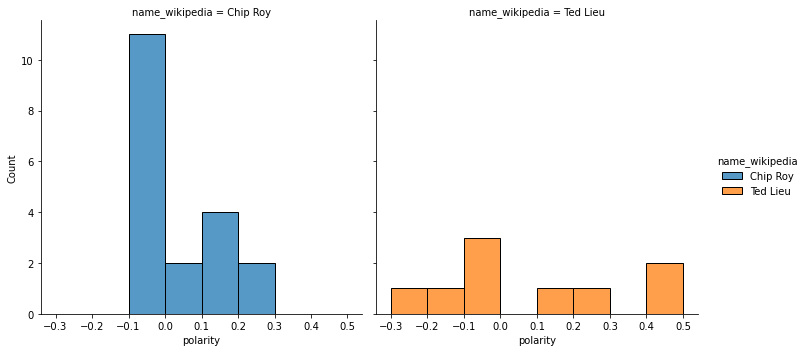

In [78]:
#Plot sentiment polarity for conservative & liberal legislators
sns.displot(sentiment_1, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

In [79]:
#Check out the most negative tweets for Chip Roy
for tweet in roy_tweets.nsmallest(3, 'polarity')['text']:
    print(tweet + "\n")

RT @RepDLesko Today I signed @SteveScalise's discharge petition to force a vote on the #BornAliveAct. Any baby born alive deserves medical care. It should be common sense to #EndInfanticide. 

#LetUsVote http://pbs.twimg.com/amplify_video_thumb/1113177393957625857/img/nOd_tixw9dgOO-bA.jpg https://video.twimg.com/amplify_video/1113177393957625857/vid/320x180/0qVTbvd8NbJ7gF3R.mp4?tag=11

RT @RepRonWright Read this! Having just returned from the border myself I strongly concur with my friend and colleague. This is a crisis and we have an emergency! #SecureOurBorder #BorderSecurity https://twitter.com/RepChipRoy/status/1110621253583417344 QT @RepChipRoy Even as our Border Patrol is on record claiming they expect to apprehend 100,000 illegal border crossers this month, Democrats forced a political show vote on whether we have an emergency at our border. We. Have. An. Emergency. At. Our. Border. 

https://roy.house.gov/media/press-releases/rep-chip-roy-national-emergency-override-vote

In No

**It's interesting that these are Roy's most negative tweets in this subset. Let's check these out a bit more to figure out what is specifically driving the negative polarity score.** 

In [86]:
#just changed to avoid hard coding

for sample_tweet in roy_tweets.nsmallest(3, 'polarity').reset_index()['text']:
    print(sample_tweet)
    print("overall polarity score is ", TextBlob(sample_tweet).sentiment.polarity)
    for word in sample_tweet.split():
        print(word, TextBlob(word).sentiment.polarity)
    print('-----------------------------------------------------')
    print()

RT @RepDLesko Today I signed @SteveScalise's discharge petition to force a vote on the #BornAliveAct. Any baby born alive deserves medical care. It should be common sense to #EndInfanticide. 

#LetUsVote http://pbs.twimg.com/amplify_video_thumb/1113177393957625857/img/nOd_tixw9dgOO-bA.jpg https://video.twimg.com/amplify_video/1113177393957625857/vid/320x180/0qVTbvd8NbJ7gF3R.mp4?tag=11
overall polarity score is  -0.06666666666666667
RT 0.0
@RepDLesko 0.0
Today 0.0
I 0.0
signed 0.0
@SteveScalise's 0.0
discharge 0.0
petition 0.0
to 0.0
force 0.0
a 0.0
vote 0.0
on 0.0
the 0.0
#BornAliveAct. 0.0
Any 0.0
baby 0.0
born 0.0
alive 0.1
deserves 0.0
medical 0.0
care. 0.0
It 0.0
should 0.0
be 0.0
common -0.3
sense 0.0
to 0.0
#EndInfanticide. 0.0
#LetUsVote 0.0
http://pbs.twimg.com/amplify_video_thumb/1113177393957625857/img/nOd_tixw9dgOO-bA.jpg 0.0
https://video.twimg.com/amplify_video/1113177393957625857/vid/320x180/0qVTbvd8NbJ7gF3R.mp4?tag=11 0.0
-------------------------------------------------

In [34]:
#Now let's check out Lieu's most negative tweets
for tweet in lieu_tweets.nsmallest(3, 'polarity')['text']:
    print(tweet + "\n")

RT @amjoyshow .@RepTedLieu: Nancy Pelosi is a badass because we're getting real border security not a stupid wall https://www.msnbc.com/am-joy/watch/nancy-pelosi-leads-democrats-to-big-wins-over-trump-on-border-security-1436486211738?cid=sm_npd_ms_tw_jy via @amjoyshow

RT @HouseJudiciary HAPPENING TODAY: @HouseJudiciary Chairman @RepJerryNadler Holds Hearing on Renewing the 911 Victims Compensation Fund with @RepMaloney and Jon Stewart. #Renew911VCF 
https://www.youtube.com/watch?v=NLKWRsDPUlk

@senatemajldr More than 275 Bipartisan bills #ForThePeople could pass today. @senatemajldr: do your job! http://pbs.twimg.com/media/EMAjoj2XkAkno6e.jpg



In [87]:
for sample_tweet in lieu_tweets.nsmallest(3, 'polarity').reset_index()['text']:
    print(sample_tweet)
    print("overall polarity score is ", TextBlob(sample_tweet).sentiment.polarity)
    for word in sample_tweet.split():
        print(word, TextBlob(word).sentiment.polarity)
    print('-----------------------------------------------------')
    print()

RT @amjoyshow .@RepTedLieu: Nancy Pelosi is a badass because we're getting real border security not a stupid wall https://www.msnbc.com/am-joy/watch/nancy-pelosi-leads-democrats-to-big-wins-over-trump-on-border-security-1436486211738?cid=sm_npd_ms_tw_jy via @amjoyshow
overall polarity score is  0.3
RT 0.0
@amjoyshow 0.0
.@RepTedLieu: 0.0
Nancy 0.0
Pelosi 0.0
is 0.0
a 0.0
badass 0.0
because 0.0
we're 0.0
getting 0.0
real 0.2
border 0.0
security 0.0
not 0.0
a 0.0
stupid -0.7999999999999999
wall 0.0
https://www.msnbc.com/am-joy/watch/nancy-pelosi-leads-democrats-to-big-wins-over-trump-on-border-security-1436486211738?cid=sm_npd_ms_tw_jy 0.0
via 0.0
@amjoyshow 0.0
-----------------------------------------------------

This is outrageous. Teachers are being forced to use their own savings to buy personal protective equipment for themselves &amp; their students. Democrats are requesting $300 billion to safely reopen our schools &amp; maintain services for students. #FamiliesFirst https://www

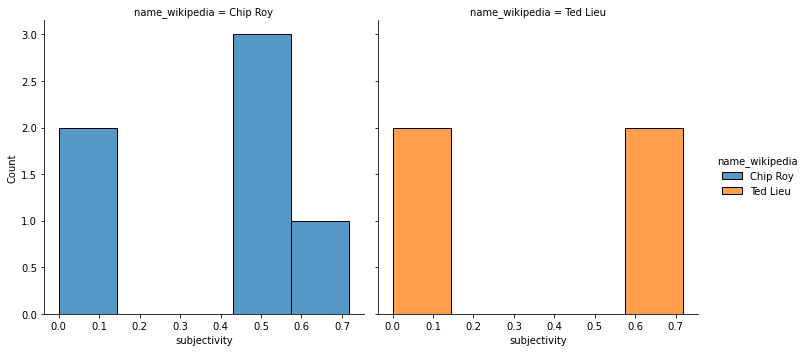

In [37]:
#Plot sentiment subjectivity for Roy and Lieu
sns.displot(sentiment_1, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

In [38]:
#Check out the most subjective tweets for Chip Roy
for tweet in roy_tweets.nsmallest(3, 'subjectivity')['text']:
    print(tweet + "\n")

RT @ESCochrane Chip Roy, the first to block the disaster relief bill over recess, is now trying to adjourn the House for the same reason. “We should be voting,” he tells me. “We should be voting on the border supplemental the president sent up months ago.” https://twitter.com/housedailypress/status/1138842431913373696 QT @HouseDailyPress The House is voting NOW on a motion by Roy (R), TX that the House adjourn.

2,347 ounces of heroin was seized on the southwest border in July.

#StateOfOurBorder
#EndBorderCrisisNow https://twitter.com/RepChipRoy/status/1169254075776610305 QT @RepChipRoy 16.96 pounds of fentanyl was seized on the southern border in July. 

Context: 2,000 micrograms will kill one person. 16.96 lbs is enough to kill 3,846,465 people.

#StateOfOurBorder #EndBorderCrisisNow

RT @RepRonWright Read this! Having just returned from the border myself I strongly concur with my friend and colleague. This is a crisis and we have an emergency! #SecureOurBorder #BorderSecurity https

In [39]:
#Check out the most subjective tweets for Ted Lieu
for tweet in lieu_tweets.nsmallest(3, 'subjectivity')['text']:
    print(tweet + "\n")

@senatemajldr More than 275 Bipartisan bills #ForThePeople could pass today. @senatemajldr: do your job! http://pbs.twimg.com/media/EMAjoj2XkAkno6e.jpg

RT @HouseJudiciary HAPPENING TODAY: @HouseJudiciary Chairman @RepJerryNadler Holds Hearing on Renewing the 911 Victims Compensation Fund with @RepMaloney and Jon Stewart. #Renew911VCF 
https://www.youtube.com/watch?v=NLKWRsDPUlk

RT @amjoyshow .@RepTedLieu: Nancy Pelosi is a badass because we're getting real border security not a stupid wall https://www.msnbc.com/am-joy/watch/nancy-pelosi-leads-democrats-to-big-wins-over-trump-on-border-security-1436486211738?cid=sm_npd_ms_tw_jy via @amjoyshow



**This definitely doesn't match what we had in mind, but illuminates both the advantages and disadvantages of sentiment analysis. Over the past four years Trump spewed excessively negative and patently false rhetoric that often trickled down to his Republican colleagues. For context, Chip Roy (R-Texas) was one of 40 representatives to vote against a covid relief bill in March 2020 and in July he blamed surging covid cases in Texas on "people coming across our border" from Mexico. As such, we expected Chip Roy's tweets to be scored as more negative and subjective. Surprisingly, that was not the case. On the other hand, Ted Lieu (D-California) was named the impeachment manager for Trump's second impeachment. So while his tweets were scored more negative and subjective, many were in condemnation of the Trump administration. Looking at Roy and Lieu's most negative and subjective tweets provides helpful context that can be lost in the sentiment analysis.** 

In [88]:
#Polarity & subjectivity for Dems vs. Republicans and House vs. Senate
congress_tweets['polarity'] = congress_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens_sent'].map(lambda text: TextBlob(text).sentiment.subjectivity)

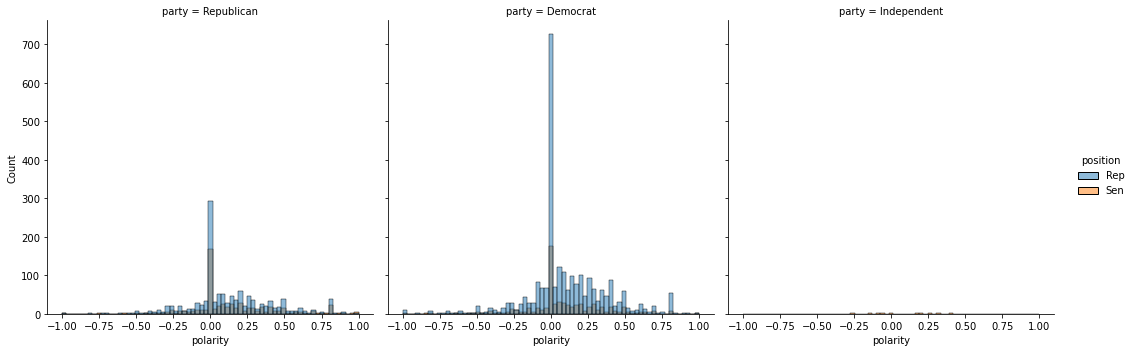

In [99]:
sns.displot(congress_tweets, x="polarity", hue = "position", col = "party")
plt.show()

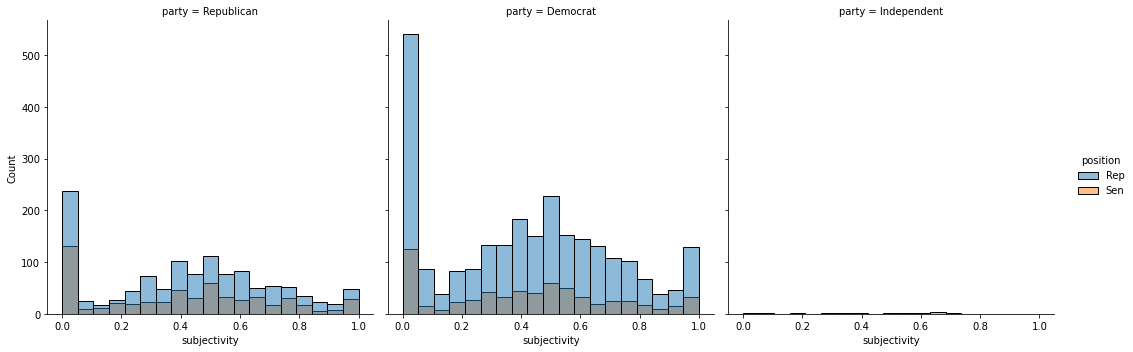

In [100]:
sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "party")
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [101]:
# Engineered Features
word_count = pd.DataFrame([len(str(x).split()) for x in congress_tweets['tokens']], columns = ['word_count'])
word_count

,word_count
0,42
1,10
2,10
3,24
4,7
...,...
4995,16
4996,5
4997,23
4998,10


In [102]:
character_count = pd.DataFrame([len(x) for x in congress_tweets['text']], columns = ['character_count'])
character_count

,character_count
0,755
1,110
2,156
3,325
4,102
...,...
4995,211
4996,162
4997,279
4998,157


In [103]:
#already generated from EDA

topic_dist_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.016219,0.016219,0.016219,0.016219,0.016219,0.480253,0.108348,0.016219,0.016219,0.297866
1,0.024398,0.024400,0.024399,0.368240,0.024398,0.436568,0.024399,0.024400,0.024398,0.024400
2,0.024724,0.024724,0.485964,0.024725,0.024724,0.024751,0.024725,0.024724,0.024724,0.316213
3,0.017479,0.017482,0.321381,0.017479,0.017479,0.538783,0.017479,0.017479,0.017480,0.017481
4,0.028129,0.530788,0.028125,0.028125,0.028126,0.244202,0.028125,0.028125,0.028125,0.028129
...,...,...,...,...,...,...,...,...,...,...
4995,0.020321,0.020324,0.020323,0.020315,0.020315,0.747411,0.020324,0.020316,0.020316,0.090035
4996,0.031636,0.031639,0.031636,0.031636,0.031636,0.031969,0.714912,0.031637,0.031641,0.031657
4997,0.076379,0.018551,0.018551,0.067394,0.018548,0.018565,0.018550,0.018555,0.018549,0.726359
4998,0.024370,0.024372,0.024370,0.024370,0.609380,0.195645,0.024376,0.024371,0.024371,0.024375


In [110]:
# review from sentiment analysis goes here
congress_tweets.polarity
congress_tweets.subjectivity

36257     0.625000
548996    0.666667
652347    0.500000
267614    0.500000
344386    0.000000
            ...   
808467    0.388889
708752    0.666667
7587      0.411111
930878    0.100000
277874    0.033333
Name: subjectivity, Length: 5000, dtype: float64

In [115]:
# combine into dataframe
engineered_features = topic_dist_df.join(character_count).\
join(word_count).join(congress_tweets[['subjectivity', 'polarity']].reset_index(drop=True))

engineered_features

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,character_count,word_count,subjectivity,polarity
0,0.016219,0.016219,0.016219,0.016219,0.016219,0.480253,0.108348,0.016219,0.016219,0.297866,755,42,0.625000,0.433333
1,0.024398,0.024400,0.024399,0.368240,0.024398,0.436568,0.024399,0.024400,0.024398,0.024400,110,10,0.666667,-0.333333
2,0.024724,0.024724,0.485964,0.024725,0.024724,0.024751,0.024725,0.024724,0.024724,0.316213,156,10,0.500000,0.500000
3,0.017479,0.017482,0.321381,0.017479,0.017479,0.538783,0.017479,0.017479,0.017480,0.017481,325,24,0.500000,-0.437500
4,0.028129,0.530788,0.028125,0.028125,0.028126,0.244202,0.028125,0.028125,0.028125,0.028129,102,7,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.020321,0.020324,0.020323,0.020315,0.020315,0.747411,0.020324,0.020316,0.020316,0.090035,211,16,0.388889,-0.277778
4996,0.031636,0.031639,0.031636,0.031636,0.031636,0.031969,0.714912,0.031637,0.031641,0.031657,162,5,0.666667,0.333333
4997,0.076379,0.018551,0.018551,0.067394,0.018548,0.018565,0.018550,0.018555,0.018549,0.726359,279,23,0.411111,0.083333
4998,0.024370,0.024372,0.024370,0.024370,0.609380,0.195645,0.024376,0.024371,0.024371,0.024375,157,10,0.100000,0.000000


### Bag-of-words or Tf-idf

In [116]:
# Frequency Based featurization
# turn tfidf matrix into data frame
#tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
tfidf_matrix

<5000x15030 sparse matrix of type '<class 'numpy.float64'>'
	with 93457 stored elements in Compressed Sparse Row format>

In [134]:
#from sklearn.preprocessing import StandardScaler

#X_tfidf = StandardScaler().fit_transform(tfidf_matrix)

#have found some discussion that if keeping it sparse is justified, 
#then it is okay to not densify by normalizing... 

## Word Embeddings

In [118]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

Using our tokenized corpus to update the Google News embeddings. 

In [119]:
# retrain cfpb['tokens'] model so it has the same dimensions as the google vector

import multiprocessing

word2vec_model = gensim.models.Word2Vec(size = 300, window=5, min_count = 1,
                                        workers = (multiprocessing.cpu_count()))
word2vec_model.build_vocab(congress_tweets['tokens'])

In [120]:
# the intersect code that loads the Google News embeddings

# set lockf = 1 to allow updating

word2vec_model.intersect_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

# Finish training model
word2vec_model.train(congress_tweets['tokens'], total_examples=3, epochs = 5)

(486607, 505410)

Exploring word embeddings (with Google News loaded) using t-SNE visualization. 

In [121]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
#words = list(model.wv.vocab)
vector_list = [word2vec_model.wv.__getitem__(word) for word in word2vec_model.wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in word2vec_model.wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape

(15030, 300)

Looks lke our word embeddings pulled out 4,079 unique tokens that matched the criteria for Word2Vec (do we know what these criteria are??) 

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127468 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127468 missing from current font.
  font.set_text(s, 0, flags=flags)


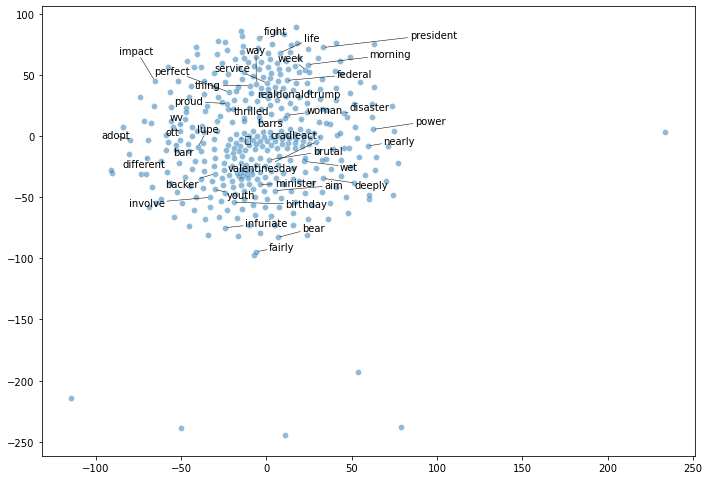

In [122]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'pca', perplexity = 30)

# Use 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

# Use adjustText to jitter the labels
from adjustText import adjust_text
texts = []
words_to_plot = list(numpy.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], word_vec_df.index[word], fontsize = 10))
    
adjust_text(texts, force_points = 0.4, force_text = 0.2, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

I don't see so much separation, but can see some potentially meaningful proximities? 

Towards the upper right: bank, credit, firm, investment, trade, product 

Also in the vicinity: children, wife 

And then leftish: comment, story, tell 

Going to try PCA on the vectors... 

<AxesSubplot:>

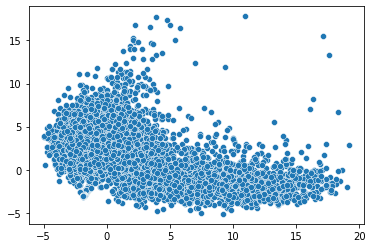

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = word2vec_model.wv.__getitem__(word2vec_model.wv.vocab)
# scale the data
X_std = StandardScaler().fit_transform(X)

# make a PCA
w2v_pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

# fit the standardized data
Y_pca = w2v_pca.fit_transform(X_std)

sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128665 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128064 missing from current font.
  font.set_text(s, 0, flags=flags)


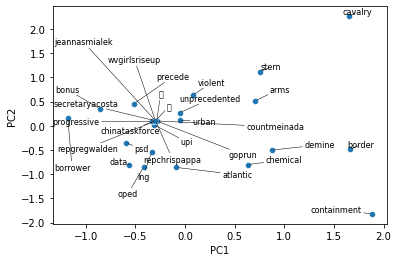

In [124]:
import random
random.seed(10)
rando = random.sample(list(word2vec_model.wv.vocab), 30)

X1 = word2vec_model.wv.__getitem__(rando)
pca1 = PCA(n_components=2)
result = w2v_pca.fit_transform(X1)
result_df = pd.DataFrame(result, columns = ['PC1', 'PC2'], index = rando)
sns.scatterplot(x = 'PC1', y = 'PC2', data = result_df)

from adjustText import adjust_text
texts = []

# Append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], result_df.loc[word, 'PC2'], word, fontsize = 8))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Lol well... Interesting that both "protect" and "govt" are quite far from the mass of the (randomly sampled) vocabulary, and also somewhat far from each other. Also "october" and "twitter" being close together...? Something about the leadup to the November election? Sorry this is not a particularly well thought out interpretation LOL

Creating the averaged embeddings for each document. 

In [125]:
import numpy as np

# Function to average word embeddings for a document; 
#use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.

#added the else clause in the return statement for any docs that have no words in the model vocab

def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.vocab]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0) if len(doc) > 0 else np.empty(word2vec_model.vector_size)

In [126]:
#np.vstack takes the list from the list comprehension code
# and "stacks" vertically to form a single array 
docavgs = np.vstack([document_vector(word2vec_model, x) for x in congress_tweets['tokens']])

<AxesSubplot:>

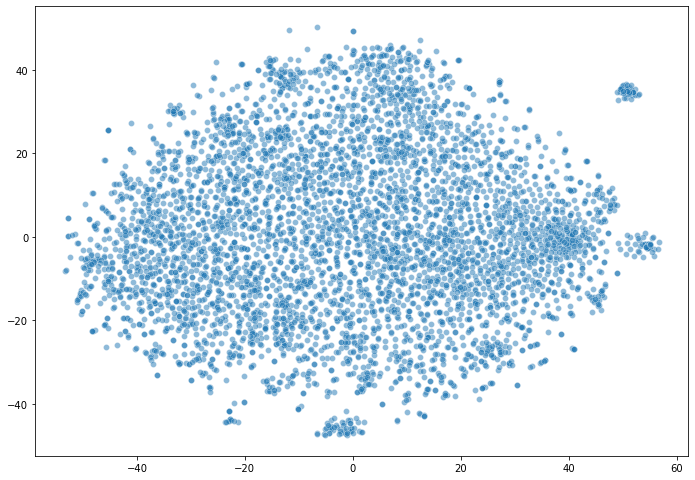

In [127]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'pca', perplexity = 30)

# Use 400 rows to speed up training time
tsne_df = tsne.fit_transform(docavgs)

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)


Lol just one big blob :( 

Just curious... going to PCA the word averaged document embeddings. 

<AxesSubplot:>

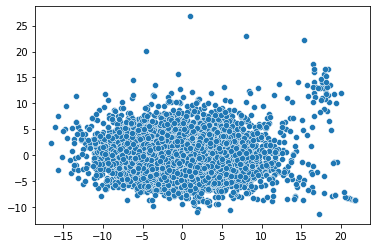

In [128]:
X = docavgs
# scale the data
X_std = StandardScaler().fit_transform(X)

# make a PCA
w2v_pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

# fit the standardized data
Y_pca = w2v_pca.fit_transform(X_std)

sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])

Okay two clusters !! 

In [143]:
#congress_tweets.set_index(["party"]).count(level = 'party')

congress_tweets.reset_index().groupby('party').count()

set(congress_tweets['party'])

{'Democrat', 'Independent', 'Republican'}

<Figure size 432x288 with 0 Axes>

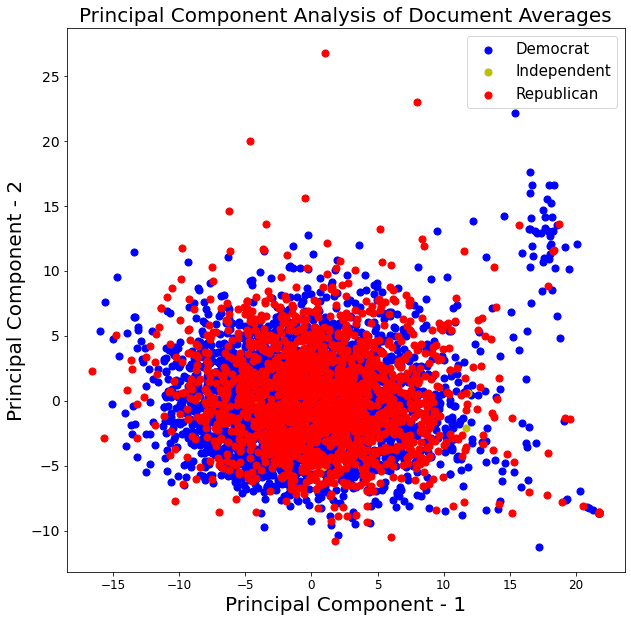

In [146]:
pca_df = pd.DataFrame(data = Y_pca
             , columns = ['principal component 1', 'principal component 2'])

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Document Averages",fontsize=20)
targets = set(congress_tweets['party'])
colors = ['b','y', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = congress_tweets.reset_index()['party'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

from adjustText import adjust_text
texts = []

# Append name_wikipedia to list
# this looks very bad lol, too many names
'''for word in pca_df.index:
    texts.append(plt.text(pca_df.loc[word, 'principal component 1'],
                          pca_df.loc[word, 'principal component 1'], 
                          congress_tweets.reset_index().loc[word, 'name_wikipedia'], fontsize = 8))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))'''

plt.show()

<Figure size 432x288 with 0 Axes>

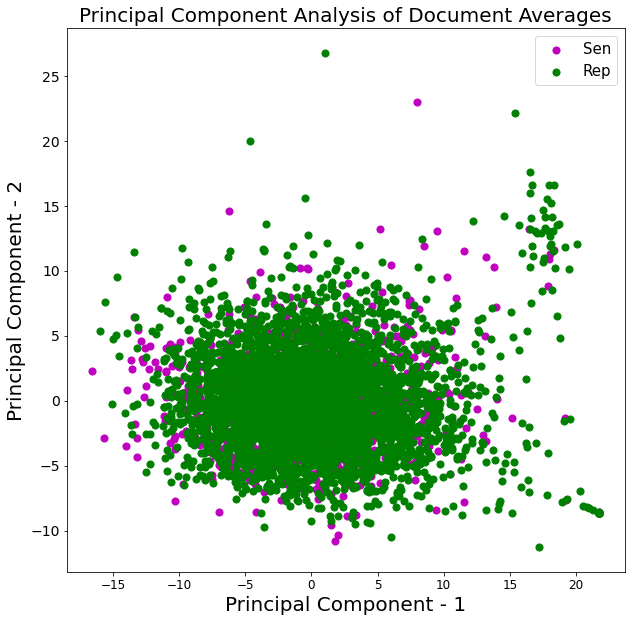

In [147]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Document Averages",fontsize=20)
targets = set(congress_tweets['position'])
colors = ['m', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = congress_tweets.reset_index()['position'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

Um... If there is a separation, doesn't look like it's super meaningful to our questions lol. 

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

### Jasmine

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

In [219]:
engineered_features

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,character_count,word_count,subjectivity,polarity
0,0.016219,0.016219,0.016219,0.016219,0.016219,0.480253,0.108348,0.016219,0.016219,0.297866,755,42,0.625000,0.433333
1,0.024398,0.024400,0.024399,0.368240,0.024398,0.436568,0.024399,0.024400,0.024398,0.024400,110,10,0.666667,-0.333333
2,0.024724,0.024724,0.485964,0.024725,0.024724,0.024751,0.024725,0.024724,0.024724,0.316213,156,10,0.500000,0.500000
3,0.017479,0.017482,0.321381,0.017479,0.017479,0.538783,0.017479,0.017479,0.017480,0.017481,325,24,0.500000,-0.437500
4,0.028129,0.530788,0.028125,0.028125,0.028126,0.244202,0.028125,0.028125,0.028125,0.028129,102,7,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.020321,0.020324,0.020323,0.020315,0.020315,0.747411,0.020324,0.020316,0.020316,0.090035,211,16,0.388889,-0.277778
4996,0.031636,0.031639,0.031636,0.031636,0.031636,0.031969,0.714912,0.031637,0.031641,0.031657,162,5,0.666667,0.333333
4997,0.076379,0.018551,0.018551,0.067394,0.018548,0.018565,0.018550,0.018555,0.018549,0.726359,279,23,0.411111,0.083333
4998,0.024370,0.024372,0.024370,0.024370,0.609380,0.195645,0.024376,0.024371,0.024371,0.024375,157,10,0.100000,0.000000


In [221]:
list(engineered_features.columns)

['Topic 0',
 'Topic 1',
 'Topic 2',
 'Topic 3',
 'Topic 4',
 'Topic 5',
 'Topic 6',
 'Topic 7',
 'Topic 8',
 'Topic 9',
 'character_count',
 'word_count',
 'subjectivity',
 'polarity']

In [239]:
#engineered_features_df = pd.get_dummies(engineered_features_df)
X_sentiment = StandardScaler().fit_transform(engineered_features)

In [79]:
#Set target variable(s)
lb_style = LabelBinarizer()
y_1 = lb_style.fit_transform(congress_tweets['party'].replace('Independent','Democrat'))
y_2 = lb_style.fit_transform(congress_tweets['position'].replace('Independent','Democrat'))

#target_variables = [y_1, y_2] - stole this from you audrey but ended up running the hyperparameters separately for the different y because I kept getting errors
#target_titles = ['Political Party', 'Senate or House?']
#matrix_cols = [{0: "Republican", 1: "Democrat"}, {0: "Senator", 1: "Representative"}]
#matrix_cols_index = [["Republican", "Democrat"], ["Senator", "Representative"]]

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, make_scorer, f1_score, precision_score, recall_score


In [ ]:
#create a model for political party
logit_reg = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_reg, param_grid, cv=3, iid=False, verbose = 2,
                          scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1,  
                           refit = 'accuracy')
logit_grid.fit(X_sentiment, y_1)

metrics = ["params", "mean_test_accuracy", "mean_test_precision",
           "mean_test_recall", "mean_test_f1", "mean_fit_time"]
for i in metrics:
    print(i, ":", logit_grid.cv_results_[i][logit_grid.best_index_])

In [ ]:
#Run political party with hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X_sentiment, 
                                                    y_1, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)
logit_tune = LogisticRegression(C = 0.1,
                              fit_intercept = True,
                              penalty = 'l1',
                              solver = 'liblinear')

logit_model= logit_tune.fit(X_train, y_train.ravel())

y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Political Party?')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
#Create a model for senate vs house
logit_reg_2 = LogisticRegression()

param_grid_2 = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
               'fit_intercept': ['True', 'False'],
             'solver': ['liblinear', 'saga']}

logit_grid_2 = GridSearchCV(logit_reg_2, param_grid_2, cv=3, iid=False, verbose = 2,
                          scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1,  
                           refit = 'accuracy')
logit_grid_2.fit(X_sentiment, y_2)

metrics = ["params", "mean_test_accuracy", "mean_test_precision",
           "mean_test_recall", "mean_test_f1", "mean_fit_time"]
    
for i in metrics:
    print(i, ":", logit_grid_2.cv_results_[i][logit_grid_2.best_index_])

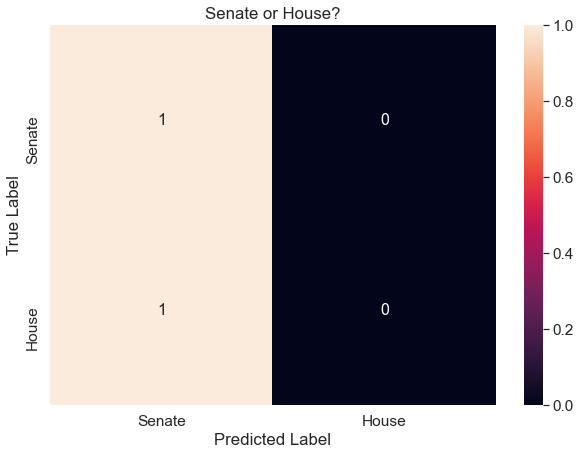

In [91]:
#Run senate vs house with hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X_sentiment, 
                                                    y_2, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)
logit_tune_2 = LogisticRegression(C = 0.1,
                              fit_intercept = True,
                              penalty = 'l1',
                              solver = 'liblinear')

logit_model_2= logit_tune_2.fit(X_train, y_train.ravel())

y_pred = logit_model_2.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Senate", 1: "House"})
df_cm.index = ["Senate", "House"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Senate or House?')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Paul

### Doc2Vec

In [178]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# binarize label
lb_style = LabelBinarizer()
y = lb_style.fit_transform(congress_tweets['party'].replace('Independent', 'Democrat'))

train, test = train_test_split(congress_tweets, test_size=0.2, random_state=42)


In [179]:
ct_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'], 
                                tags=[r.party.replace('Independent', 'Democrat')]), axis=1)
ct_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], 
                                tags=[r.party.replace('Independent', 'Democrat')]), axis=1)

ct_train_tagged

693997    ([repdavidtrone, medicare, amp, medicaid, repr...
360821    ([repdustyjohnson, constitution, authority, la...
565910    ([hearourheroe, eliminate, burdensome, timeori...
852954    ([yesterday, federal, judge, criticize, ag, ba...
610152    ([committee, house, administration, hold, mark...
                                ...                        
527574    ([repandylevin, facebook, happy, allow, politi...
615264    ([lsctweet, lsc, award, million, legalaidnc, a...
755918    ([senate, democrats, want, activist, judge, in...
352263    ([approximately, million, new, yorker, coronav...
539901    ([president, dictator, power, close, border, m...
Length: 4000, dtype: object

In [180]:
from multiprocessing import cpu_count
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cpu_count())
model_dbow.build_vocab([x for x in tqdm(ct_train_tagged.values)])

100%|██████████| 4000/4000 [00:00<00:00, 1241836.86it/s]


In [182]:
from sklearn import utils

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(ct_train_tagged.values)]), 
                     total_examples=len(ct_train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 4000/4000 [00:00<00:00, 2619393.60it/s]


In [183]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [184]:
y_doc2vec, X_doc2vec = vec_for_learning(model_dbow, ct_train_tagged)

In [185]:
from sklearn.preprocessing import StandardScaler

X_std_doc2vec = StandardScaler().fit_transform(X_doc2vec)

In [186]:
logit_init = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
            'C': np.arange(.1, 1, .2),
            'solver': ['saga'],
             'l1_ratio': np.arange(0,1,0.2)}
        
log_grid_reg = GridSearchCV(logit_init, param_grid, cv=3, iid=False)

log_grid_reg.fit(X_std_doc2vec, y_doc2vec)

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/l

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/l

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:

GridSearchCV(cv=3, estimator=LogisticRegression(), iid=False,
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                         'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga']})

In [194]:
print('Parameters: ', log_grid_reg.best_params_)
print('Accuracy: ', log_grid_reg.cv_results_['mean_test_score'][log_grid_reg.best_index_])

Parameters:  {'C': 0.1, 'l1_ratio': 0.8, 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy:  0.6520022059487885


In [211]:
log_grid_reg.best_estimator_

LogisticRegression(C=0.1, l1_ratio=0.8, penalty='elasticnet', solver='saga')

In [213]:
from sklearn.metrics import confusion_matrix

y_test_doc2vec, X_test_doc2vec = vec_for_learning(model_dbow, ct_test_tagged)
X_test_doc2vec = StandardScaler().fit_transform(X_test_doc2vec)

imba_pipeline = make_pipeline(SMOTE(random_state=10), 
                             log_grid_reg.best_estimator_)

imba_pipeline.fit(X_std_doc2vec, y_doc2vec)

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('smote', SMOTE(random_state=10)),
                ('logisticregression',
                 LogisticRegression(C=0.1, l1_ratio=0.8, penalty='elasticnet',
                                    solver='saga'))])

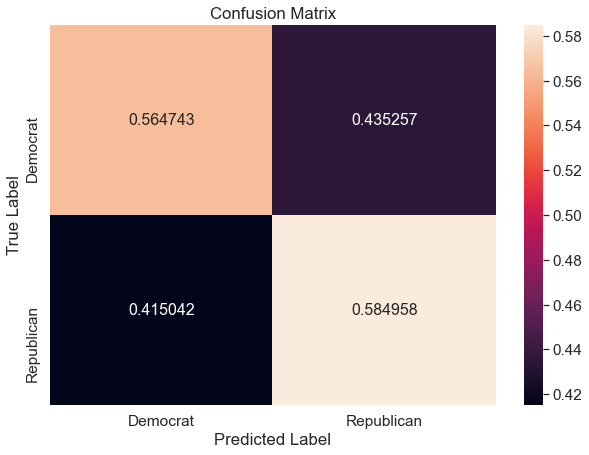

In [214]:
y_pred = imba_pipeline.predict(X_test_doc2vec)

cf_matrix = confusion_matrix(y_test_doc2vec, y_pred, normalize = "true", labels = ['Democrat', 'Republican'])

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Word2Vec Embeddings

In [218]:
from sklearn.preprocessing import LabelBinarizer

X_std = StandardScaler().fit_transform(docavgs)
y = LabelBinarizer().fit_transform(congress_tweets['party'].replace('Independent', 'Democrat'))



In [ ]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 


param_grid = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
              'logisticregression__solver' : ['saga'],
             "logisticregression__max_iter": [1000], 
             'logisticregression__l1_ratio': np.arange(0, 1, 0.2)}

log_grid_reg3 = GridSearchCV(imba_pipeline, param_grid, cv=3, iid=False, 
                            scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1,  
                           refit = 'accuracy') 
log_grid_reg3.fit(X_std, y.ravel())


In [ ]:
metrics = ["params", "mean_test_accuracy", "mean_test_precision", 
           "mean_test_recall", "mean_test_f1", "mean_fit_time"]

for i in metrics:
    print(i, ":", log_grid_reg3.cv_results_[i][log_grid_reg3.best_index_])

### Audrey

We create our two vectors of target values, y.

In [247]:
from sklearn.preprocessing import LabelBinarizer

lb_style = LabelBinarizer()
y_party = lb_style.fit_transform(congress_tweets['party'].replace('Independent','Democrat')) # predict party affiliation
y_position = lb_style.fit_transform(congress_tweets['position'].replace('Independent','Democrat')) # predict position

We create lists of targets and featurization dataframes to loop through, including indices and labels for confusion matrices.

<5000x15030 sparse matrix of type '<class 'numpy.float64'>'
	with 93457 stored elements in Compressed Sparse Row format>

In [248]:


target = [y_party, y_position] # the target variables

all_Xs = [X_sentiment, tfidf_matrix, X_std]

target_title = ['Party', 'Senator or Representative?'] # the title of the model

cm_cols = [{0: "Republican", 1: "Democrat"}, {0: "Senator", 1: "Representative"}] # dims of cm

cm_cols_index = [["Republican", "Democrat"], ["Senator", "Representative"]] # indices of cm

In [245]:
logit_init = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2'],
             'solver': ['saga']}
        
log_grid_reg = GridSearchCV(logit_init, param_grid, cv=3, iid=False,
                        scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1, 
                       refit = 'accuracy')

log_grid_reg.fit(tfidf_matrix, y_position.ravel())

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(), iid=False, n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2'], 'solver': ['saga']},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [246]:
log_grid_reg.best_estimator_

LogisticRegression(penalty='l1', solver='saga')

We create a loop that loops through the two target variables, loops through the three dataframes, and does the following: tunes hyperparameters, splits into train and text, fits new models with hyperparameters, and creates six confusion matrices.

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


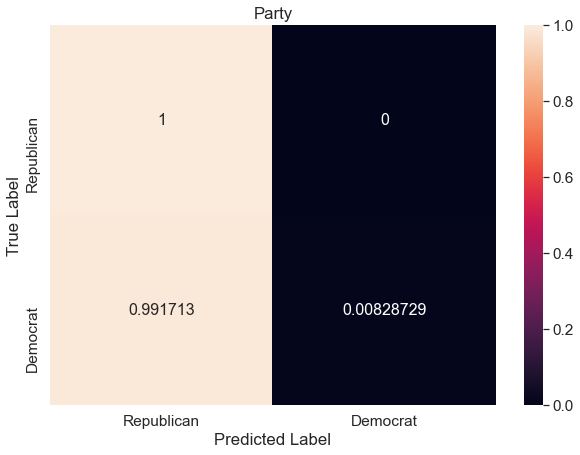

/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/Users/paul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


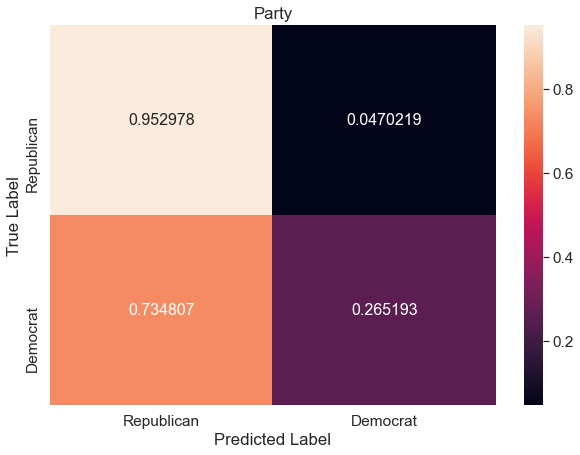

In [ ]:
# consolidated loop

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

for target_vals, target_name, cmc, cmci in zip(target, target_title, cm_cols, cm_cols_index):
    for dataframe in all_Xs:
        
        logit_init = LogisticRegression()

        param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
             'C': np.arange(.1, 1, .1),
             'solver': ['saga'],
            'l1_ratio': np.arange(0.1,0.9,0.1)}
        
        log_grid_reg = GridSearchCV(logit_init, param_grid, cv=3, iid=False,
                        scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1, 
                       refit = 'accuracy')

        log_grid_reg.fit(dataframe, target_vals.ravel())
        
        X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    target_vals, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)
           
        # insert hyperparameters here
        logit_reg = log_grid_reg.best_estimator_
        
        logit_model = logit_reg.fit(X_train, y_train.ravel())

        y_pred = logit_model.predict(X_test)

        cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

        df_cm = pd.DataFrame(cf_matrix, range(2),
                          range(2))

        df_cm = df_cm.rename(index=str, columns=cmc)
        df_cm.index = cmci
        plt.figure(figsize = (10,7))
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm, 
                   annot=True,
                   annot_kws={"size": 16},
                   fmt='g')

        plt.title(target_name)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

### Two Combined Models

We create the dataframe of non-text features, dummify it, concatenate it with our best featurization, and scale it.

In [87]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])

# df of non-text features

non_text_df = congress_tweets[['gender',
 'state',
 'trump_2016_state_share',
 'clinton_2016_state_share',
 'obama_2012_state_share',
 'romney_2012_state_share']]

In [88]:
# dummify

non_text_df = pd.get_dummies(non_text_df)

In [90]:
# concatenate arrays
best_text_non_text = np.concatenate((np.array(non_text_df),docavgs), axis = 1)

best_text_non_text

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -1.10767884e-02,  3.20460298e-03,  6.13002223e-04],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -8.85592327e-02,  2.50332393e-02, -2.85905153e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -1.08014345e-01, -3.27322558e-02,  5.82820177e-02],
       ...,
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -4.54381965e-02,  4.49864790e-02,  2.79577286e-03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -8.07971805e-02, -9.84418578e-03,  1.37773501e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -3.15265320e-02,  7.56985769e-02,  8.57947487e-03]])

In [91]:
# scale

X_final = StandardScaler().fit_transform(best_text_non_text)

Finally, we loop through the two target variables using this single dataframe, tuning hyperparameters, fitting models, and creating the final two confusion matrices.

/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


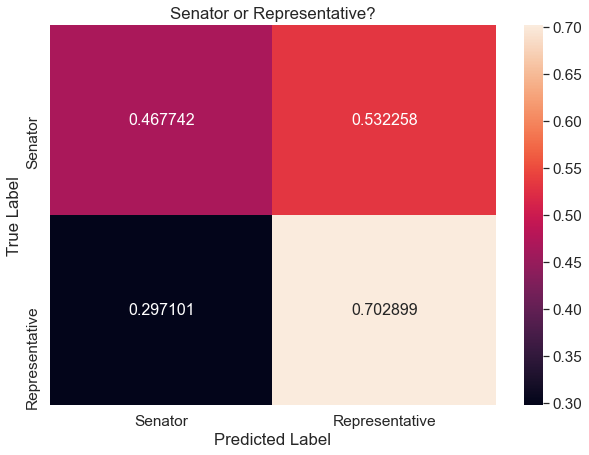

/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


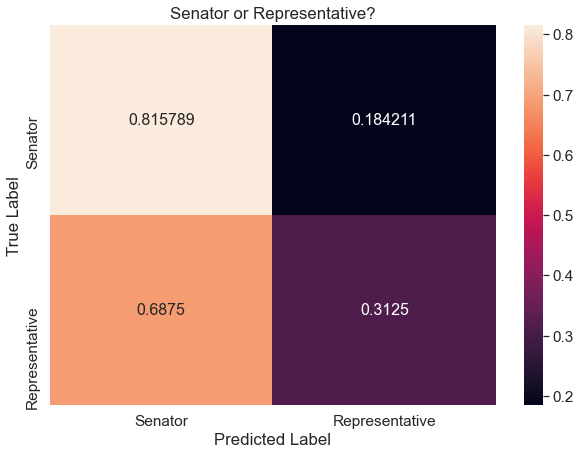

In [92]:
# re-run the loop over the two targets with the best set of text predictors and the non text predictors

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

for target_vals, target_name, cmc, cmci in zip(target, target_title, cm_cols, cm_cols_index):
    
    imba_pipeline = make_pipeline(SMOTE(random_state=10),
                         LogisticRegression())
    
    param_grid = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
          'logisticregression__solver' : ['newton-cg', 'lbfgs', 'saga'],
         "logisticregression__max_iter": [1000],
         'logisticregression__l1_ratio': numpy.arange(0, 1, 0.2)}

    log_grid_reg3 = GridSearchCV(imba_pipeline, param_grid, cv=3, iid=False,
                        scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1, 
                       refit = 'accuracy')

    log_grid_reg3.fit(X_final, target_vals.ravel()) # switch df to best

    best_params = log_grid_reg3.cv_results_["params"][log_grid_reg3.best_index_]
        
    l1_ratio = best_params['logisticregression__l1_ratio']
    penalty = best_params['logisticregression__penalty']
    solver = best_params['logisticregression__solver']
    max_iter = best_params['logisticregression__max_iter']
        
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    target_vals, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)
           
    # insert hyperparameters here
    logit_reg = LogisticRegression(l1_ratio = l1_ratio,
                                  penalty = penalty,
                                  solver = solver,
                                  max_iter = max_iter)
        
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)

    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                          range(2))

    df_cm = df_cm.rename(index=str, columns=cmc)
    df_cm.index = cmci
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
                   annot=True,
                   annot_kws={"size": 16},
                   fmt='g')

    plt.title(target_name)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**